In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import os.path
from   os import path
import shutil
import tensorflow as tf
import itertools
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb
from keras.layers import GlobalAveragePooling2D


from keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import DenseNet169,DenseNet121,InceptionV3, Xception, ResNet101
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Constants
FOLDERS     = ['train','val','test']
DIR_INPUT   = '/content/drive/MyDrive/kaggle/alzheimer_data/Alzheimer_s Dataset'
DIR_WORK    = './'
DIR_MODELS  = os.path.join(DIR_WORK,'models')
DIR_TRAIN   = os.path.join(DIR_WORK,'train')
DIR_VAL     = os.path.join(DIR_WORK,'val')
DIR_TEST    = os.path.join(DIR_WORK,'test')
CLASS_LIST  = ['MildDememted','ModerateDemented','NonDememted','VeryMildDemented']


# Set seeds for reproducibility 
SEED        = 1985
tf.random.set_seed(SEED)
np.random.seed(SEED)
def images_by_class(path, folders):
    """
    Loop through the path/folders count the number and proportions of each class
    """
    
    # accumulators
    normal,verymild,mild,moderate =0,0,0,0
    
    # print header
    msg = '{:8} {:8} {:11} {:7} {:9} {:9} {:11} {:8} {:8}'.format('folder','NonDem','VeryMilddem','MildDem','Moderatedem',
                                                        'NonDem %','VeryMildDem %','MildDeme %','Moderatedem %')
    print(msg)  
    print("-"*len(msg))
    
    for folder in FOLDERS:
        for dirname,_, filenames in os.walk(os.path.join(path,folder)):
            for file in filenames:
                if "NonDemented" in dirname:
                    normal+=1
                if "VeryMildDemented" in dirname:
                    verymild+=1
                if 'MildDemented' in dirname:
                    mild+=1
                if 'ModerateDemented' in dirname:
                    moderate+=1
                    
        # calculate total and percentages            
        total = normal+verymild+mild+moderate
        if total >0:
            n  = round(normal/total,2)*100
            vm = round(verymild/total,2)*100
            m  = round(mild/total,2)*100
            mo =round(moderate/total,2)*100
        else:
            n,vm,m,mo = 0,0,0,0
        
        print("{:6} {:8} {:10} {:7} {:11} {:8} {:10} {:8} {:12}".format(folder,normal,verymild,mild,moderate,n,vm,m,mo))
        normal,verymild,mild,moderate =0,0,0,0

# Images by class in the input directory
images_by_class(DIR_INPUT,FOLDERS)

folder   NonDem   VeryMilddem MildDem Moderatedem NonDem %  VeryMildDem % MildDeme % Moderatedem %
--------------------------------------------------------------------------------------------------
train         0          0       0           0        0          0        0            0
val           0          0       0           0        0          0        0            0
test          0          0       0           0        0          0        0            0


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:

train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/kaggle/alzheimer_data/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 60)

FileNotFoundError: ignored

In [ ]:

valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/kaggle/alzheimer_data/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 60)

Found 254 images belonging to 4 classes.



100%|██████████| 5/5 [01:37<00:00, 19.50s/it]


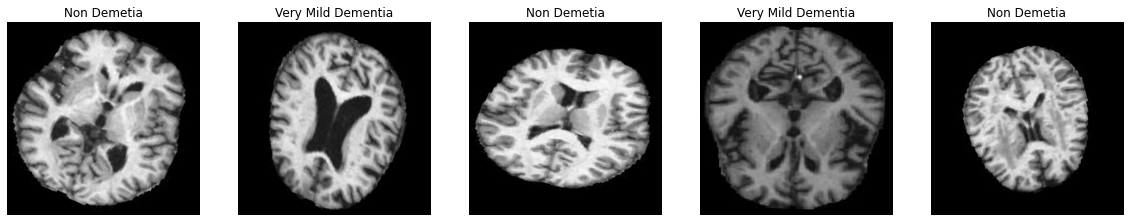

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(65)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

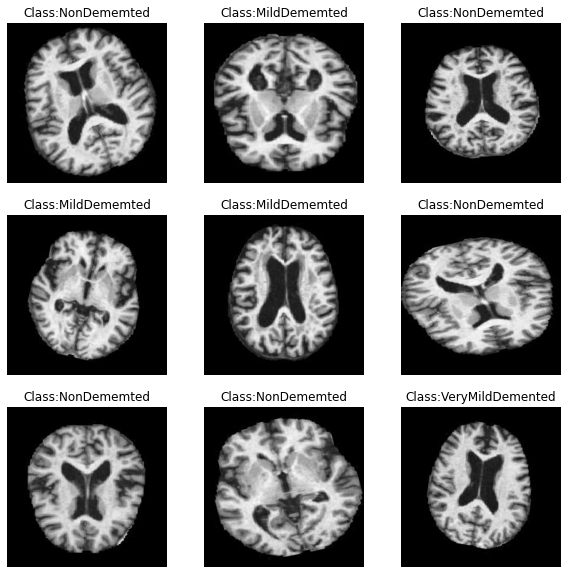

In [ ]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASS_LIST))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[i])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_dataset)

In [ ]:
vgg19model = VGG19(input_shape=(48,48,3), 
                   include_top=False,
                   weights="imagenet")
# Freezing Layers

for layer in vgg19model.layers:
    layer.trainable=False

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
vgg19model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Building Model

model=Sequential()
model.add(vgg19model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [ ]:
# Model Compile

METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)
# Defining Callbacks


filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 25,
                        callbacks = callback_list,
                        verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/25
69/69 [==============================] - 1255s 18s/step - loss: 1.4237 - auc: 0.7701 - val_loss: 0.9119 - val_auc: 0.8419

Epoch 00001: val_auc improved from -inf to 0.84193, saving model to ./best_weights.hdf5
Epoch 2/25
69/69 [==============================] - 48s 696ms/step - loss: 1.1116 - auc: 0.8113 - val_loss: 0.8760 - val_auc: 0.8579

Epoch 00002: val_auc improved from 0.84193 to 0.85789, saving model to ./best_weights.hdf5
Epoch 3/25
69/69 [==============================] - 48s 692ms/step - loss: 1.0166 - auc: 0.8300 - val_loss: 0.8773 - val_auc: 0.8493

Epoch 00003: val_auc did not improve from 0.85789
Epoch 4/25
69/69 [==============================] - 48s 695ms/step - loss: 0.9705 - auc: 0.8400 - val_loss: 0.8409 - val_auc: 0.8653

Epoch 00004: val_auc improved from 0.85789 to 0.86530, saving model to ./best_weights.hdf5
Epoch 5/25
69/69 [==============================] - 48s 692ms/step - loss: 0.9260 - auc: 0.8483 - val_loss: 0.8165 - val_auc: 0.8710

Epoch 0000

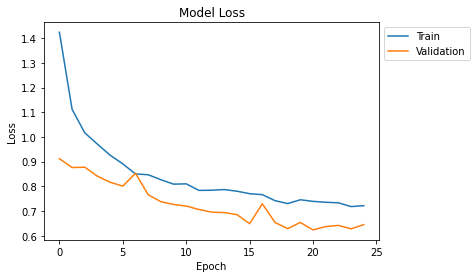

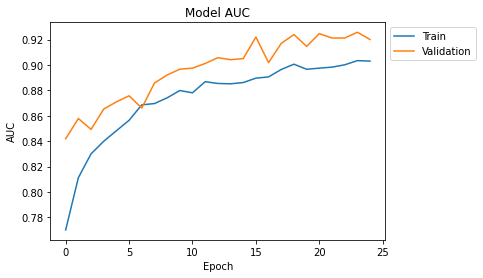

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

# Summarize history for accuracy
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
result = model.evaluate(valid_dataset, steps=128)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

128/128 [==============================] - 2s 8ms/step - loss: 0.6450 - auc: 0.9201
Test-set classification accuracy: 92.01%


In [ ]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [ ]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/kaggle/alzheimer_data/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 60)

Found 1279 images belonging to 4 classes.


In [ ]:
result = model.evaluate(test_dataset)

22/22 [==============================] - 318s 15s/step - loss: 0.8459 - auc: 0.8866


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


49.42 % chances are there that the image is MildDemented


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


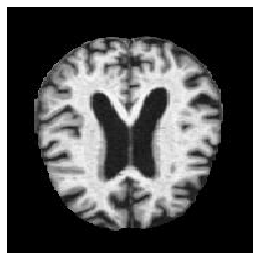

In [ ]:
# Test Case 1:MildDemented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/kaggle/alzheimer_data/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

87.19 % chances are there that the image is NonDemented


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


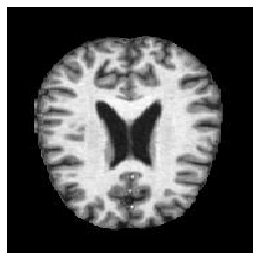

In [ ]:
# Test Case 2: NonDemented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/kaggle/alzheimer_data/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

95.87 % chances are there that the image is ModerateDemented


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


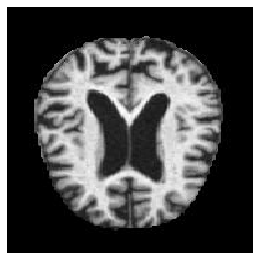

In [ ]:

# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/kaggle/alzheimer_data/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

74.18 % chances are there that the image is VeryMildDemented


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


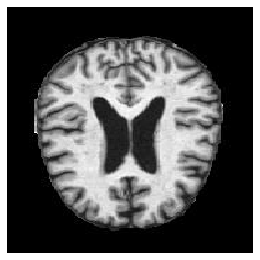

In [ ]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/kaggle/alzheimer_data/Alzheimer_s Dataset/test/VeryMildDemented/26 (44).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

In [ ]:
cls_train = valid_dataset.classes
cls_test = valid_dataset.classes
batch_size = 20
steps_test = valid_dataset.n / batch_size
steps_test

12.7

In [ ]:
class_names = list(valid_dataset.class_indices.keys())
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [ ]:
y_pred = model.predict(valid_dataset, steps=steps_test)

    # Convert the predicted classes from arrays to integers.
cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
print_confusion_matrix(cls_pred)

Confusion matrix:
[[ 1  0 23 11]
 [ 0  0  1  1]
 [ 9  1 75 43]
 [ 6  1 57 25]]
(0) MildDemented
(1) ModerateDemented
(2) NonDemented
(3) VeryMildDemented


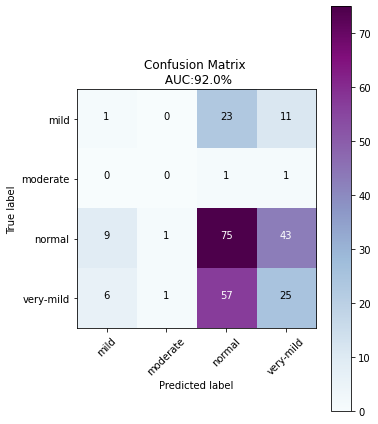

In [ ]:
test_loss, test_metric = model.evaluate(valid_dataset,verbose = False)
results       = round(test_metric,2)*100 
results_title ="\n Model AUC on Test Data:{}%".format(results)
classes=['mild','moderate','normal','very-mild']
cm = confusion_matrix(y_true=cls_test, y_pred=cls_pred)
plt.subplots(figsize=(15,6))
plt.subplot(1,3,3)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
plt.title("Confusion Matrix \n AUC:{}%".format(results))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
threshold = cm.max() / 2.
for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(c, r, format(cm[r, c], 'd'),
  horizontalalignment="center",
  color="white" if cm[r, c] > threshold else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.show()

In [ ]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
vgg19model.trainable = True
for layer in vgg19model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 15,
                        callbacks = callback_list,
                        verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15
69/69 [==============================] - 55s 770ms/step - loss: 0.9821 - auc: 0.8179 - val_loss: 1072.6818 - val_auc: 0.7383

Epoch 00001: val_auc improved from 0.66929 to 0.73827, saving model to ./best_weights.hdf5
Epoch 2/15
69/69 [==============================] - 54s 770ms/step - loss: 0.9082 - auc: 0.8384 - val_loss: 627050.5000 - val_auc: 0.6693

Epoch 00002: val_auc did not improve from 0.73827
Epoch 3/15
69/69 [==============================] - 53s 768ms/step - loss: 0.8899 - auc: 0.8433 - val_loss: 24428.5020 - val_auc: 0.6693

Epoch 00003: val_auc did not improve from 0.73827
Epoch 4/15
69/69 [==============================] - 53s 769ms/step - loss: 0.8747 - auc: 0.8508 - val_loss: 12.2661 - val_auc: 0.6772

Epoch 00004: val_auc did not improve from 0.73827
Epoch 5/15
69/69 [==============================] - 53s 763ms/step - loss: 0.8662 - auc: 0.8518 - val_loss: 0.8960 - val_auc: 0.8618

Epoch 00005: val_auc improved from 0.73827 to 0.86181, saving model to ./bes

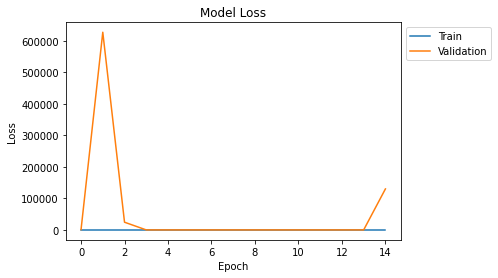

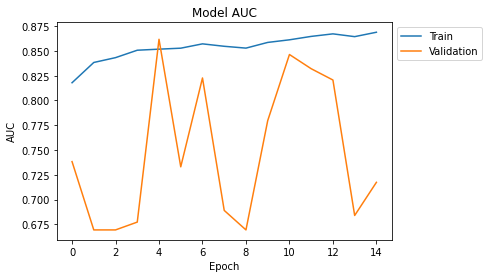

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

# Summarize history for accuracy
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
result = model.evaluate(valid_dataset, steps=128)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

128/128 [==============================] - 1s 8ms/step - loss: 130001.9609 - auc: 0.7174
Test-set classification accuracy: 71.74%


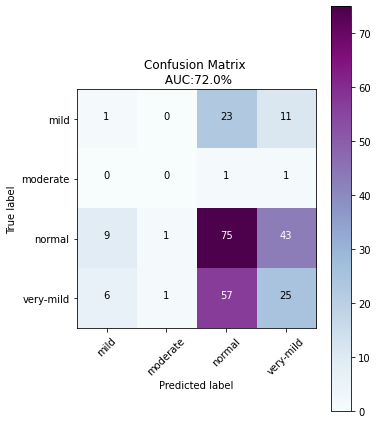

In [ ]:
test_loss, test_metric = model.evaluate(valid_dataset,verbose = False)
results       = round(test_metric,2)*100 
results_title ="\n Model AUC on Test Data:{}%".format(results)
classes=['mild','moderate','normal','very-mild']
cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)
plt.subplots(figsize=(15,6))
plt.subplot(1,3,3)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
plt.title("Confusion Matrix \n AUC:{}%".format(results))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
threshold = cm.max() / 2.
for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(c, r, format(cm[r, c], 'd'),
  horizontalalignment="center",
  color="white" if cm[r, c] > threshold else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.show()